# The Music Network

## Motivation

Everyone listens to music, music is everywhere. It exists in a multitude of variations and it naturally keeps changing over the years. But music is more than sounds and voices. Different genres and topics make music comparable and connect songs and artists. Mapping these relationships creates a dense network which we analysed in the course of this project.

There were no requirements on what kind of dataset we should pick, thus we decided to pick one that contains a lot of data:  the Million Song Dataset. This dataset contains close to one million different songs and also other related information such as: tags, years, words and even users. We got nosebleeds when we realized how much data we have, thus to make it a bit easier for us we limited amount of data we are going to work with. In the end, we got: 35525 songs, 151664 tags and 5000 lyric words that still can provide a good picture even data results can be different.
 
With our analysis we would like to show different statistics that usually people don’t even think about when listening to music, especially to think of the world of music as a network. Things that we going to show are:
* Basic network statistics (Degree distributions, high degree nodes, release year distribution,...)
* tag & similarity graphs
* Lyrics shown as wordclouds for specific tags (Death metal, Rap, Politics, Country)
* Ordering of tags by average sentiment
* Average sentiment per year
* Tags clustering based on common songs

All this can be overviewed on the final project web page http://thangout.github.io/#


## Dataset

The [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) provides us with metadata for almost one million songs. The data we used to build our network was:

* __1 file per song__ (total > 3GB) from the LastFM dataset containing:
    * id
    * artist
    * title
    * ids of similar tracks and similarity score 0-1
    * user tags and  score 1-100
* __lyrics file__ (113 MB) containing bag of words encoded lyrics for around 170000 songs and the 5000 most used words (stemmed)
* __word file__ containing a mapping of the stemmed words to the unstemmed word that is most likely
* __year file__ (35 MB) containing release year information for around 500000 songs 

The following sections assume that the data is available in a local Neo4j database. The procedure of populating the database is explained in the Appendix.

## Basic statistics

In the following we will look at key figures and distributions that describe the nature of the network subset worked on. They will give insights into the nature of the data. As we are naturally focusing on a subset of "the music of all time", it is sensible to characterize the main traits of this subset and discuss if it is representative for the complete network.

### Counting nodes and edges

In [3]:
%reload_ext cypher
import io
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
query = """
    MATCH (s:Song) 
    WITH COUNT (s) as songNodeCount
    MATCH (s:Song)-[r0:CONTAINS]->(w:Word)
    WHERE s.year IS NOT NULL
    WITH COUNT(r0) as containsCount, COUNT(DISTINCT w) as wordCount, songNodeCount
    MATCH (t:Tag)<-[r1:TAGGED]-(s:Song)-[r2:SIMILAR]->(s2:Song)
    WHERE s.year IS NOT NULL AND s2.year IS NOT NULL
    RETURN 
        COUNT(DISTINCT s) as songCount, 
        COUNT(DISTINCT r1) as taggedCount, 
        COUNT(DISTINCT r2) as similarCount,
        COUNT(DISTINCT t) as tagCount,
        wordCount,
        containsCount,
        songNodeCount
"""

r = %cypher {query}
df = r.get_dataframe()
print "Database contains"
print "%d song nodes" % df["songNodeCount"]
print "%d songs with full information (words, tags, similarities, year)" % df["songCount"]
print "%d similarity relationships between songs" % df["similarCount"]
print "%d tags" % df["tagCount"]
print "%d song-tag relationships" % df["taggedCount"]
print "%d words in the vocabulary" % df["wordCount"]
print "%d \"song contains word\" relationships" % df["containsCount"]
print
print "%.2f average number of similar songs per song" % (df["similarCount"]/float(df["songCount"]))
print "%.2f average tags per song" % (df["taggedCount"]/float(df["songCount"]))
print "%.2f average vocabulary words per song" % (df["containsCount"]/float(df["songCount"]))

1 rows affected.
Database contains
99130 song nodes
35992 songs with full information (words, tags, similarities, year)
205946 similarity relationships between songs
152775 tags
866972 song-tag relationships
5000 words in the vocabulary
3684405 "song contains word" relationships

5.72 average number of similar songs per song
24.09 average tags per song
102.37 average vocabulary words per song


Here we obtained some basic count statistics. We can see that only around a third of all nodes has full information, i.e. at least on similar song and tag and release year information. 

### Release year distribution

81 rows affected.
Year range:         1926-2010
Most frequent year: 2007 (3270 songs)


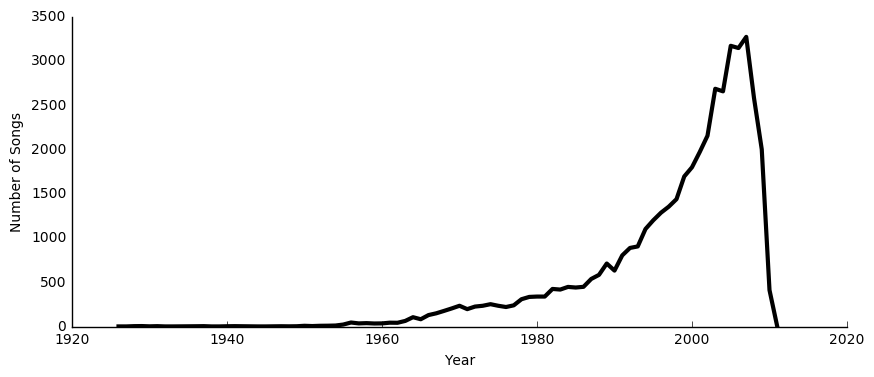

In [36]:
import matplotlib.pyplot as plt
# Aggregate by year to find distribution
r = %cypher MATCH (s:Song) WHERE s.year IS NOT NULL RETURN DISTINCT s.year as year, COUNT(s) as count ORDER BY year
df = r.get_dataframe()
years = df["year"].values.tolist()
counts = df["count"].values.tolist()
years.append(years[-1]+1)
counts.append(0)

years_sorted = sorted({year:counts[i] for i,year in enumerate(years)}.items(),key=lambda v: -v[1])
print "Year range:         %d-%d" % (np.min(years),np.max(years)-1)
print "Most frequent year: %d (%d songs)" % years_sorted[0]

_,ax = plt.subplots(1,1,figsize=(10,4))
plt.plot(years,counts,"k",linewidth=3)
plt.xlabel("Year")
plt.ylabel("Number of Songs")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('none')

plt.savefig('year_distribution.png', bbox_inches='tight')
plt.show()

Here we show the distribution of release years of the dataset. It provides important information in that it characterizes what kind of music we can expect in the database. Most of the songs are fairly recent. In fact 56% are from after 2000 and over 80% are from after 1990. 

###  Most frequent artists and tags

Let's first find the artist with most songs

In [37]:
r = %cypher MATCH (s:Song) WHERE s.artist IS NOT NULL RETURN DISTINCT s.artist as artist, COUNT(s) as count ORDER BY count DESC LIMIT 10
print r.get_dataframe()

10 rows affected.
              artist  count
0      Frank Sinatra     62
1  Bruce Springsteen     60
2           The Cure     58
3          Joan Baez     54
4        Johnny Cash     54
5       Neil Diamond     53
6          Bob Dylan     50
7     Billie Holiday     50
8      Willie Nelson     50
9       Dolly Parton     50


... and the Tags with most songs. 

In [29]:
query = """
MATCH (t:Tag)<-[r:TAGGED]-() 
RETURN 
    DISTINCT t.name as tag,
    COUNT(r) as count
ORDER BY count DESC 
LIMIT 10
"""
r = %cypher {query}
print r.get_dataframe()

10 rows affected.
                 tag  count
0               rock  17318
1                pop  10968
2        alternative   9938
3              indie   7945
4               Love   6020
5   alternative rock   5944
6              metal   5749
7  singer-songwriter   4955
8         indie rock   4580
9             Mellow   4267


The results are not particularly surprising. Obviously rock and pop are the most popular tags indicating two very popular genres. While there are a lot of tags not carrying genre information ("favourites", "best song ever", "female vocalists") in the dataset, the most common tags contain a higher proportion of genre tags. 

### Graph statistics

Now that we have the graph representation with full information in our database, we can extract partial information to construct a graph which is processable in-memory. We will focus our analysis on the giant connected component which was almost the full graph in all cases.

#### Similarity graph
The first graph we will use is the similarity graph containing Songs as nodes and similarity relationships as edges.

In [31]:
# get all similarity relationships
query ="""
MATCH (s:Song)-[r:SIMILAR]->(s2:Song)
RETURN s.id AS from, s2.id AS to, r.score AS score
"""
r = %cypher {query}
df = r.get_dataframe()

# build similarity graph
G = nx.DiGraph()
for row in df.iterrows():
    r = row[1]
    G.add_edge(r["from"],r["to"],{"score":r["score"]})

# extract largest component
H = max(nx.weakly_connected_component_subgraphs(G), key=len)
print "Largest weakly connected component contains %d of %d nodes." % (H.number_of_nodes(),G.number_of_nodes())

331774 rows affected.
Largest weakly connected component contains 61953 of 65526 nodes.


As we can see, out of the roughly 100000 nodes, there are a lot which do not have any similar songs. If we are only considering the rest almost 95% of those belong to the giant connected component.

#### Song-Tag graph
Another graph is the bipartite graph containing songs and tags. As there are about one million song-tag relationships in our database, we avoided having to construct the complete graph in-memory and extracted just the data we need for the individual tasks.

#### Degree distributions

In order to compare the two graphs, we will first look at the degree distributions of songs and tags. We let the database do the work of computing the degrees to avoid constructing the whole graph in-memory. We obtain the degree of similarity for songs (both incoming and outgoing similarity relationships to other songs) as well as the in-degree for tags, i.e. how many songs are tagged by a certain tag.

In [46]:
query = """
MATCH (s:Song)-[r:SIMILAR]-()
WHERE s.year IS NOT NULL
RETURN distinct s.id, count(r)
"""

r = %cypher {query}
sim_degrees = r.get_dataframe().values[:,1]

query = """
MATCH (s:Song)-[r:TAGGED]->(t:Tag)
WHERE s.year IS NOT NULL
RETURN distinct t.name, count(r)
"""
r = %cypher {query}
tag_degrees = r.get_dataframe().values[:,1]

45579 rows affected.
161833 rows affected.


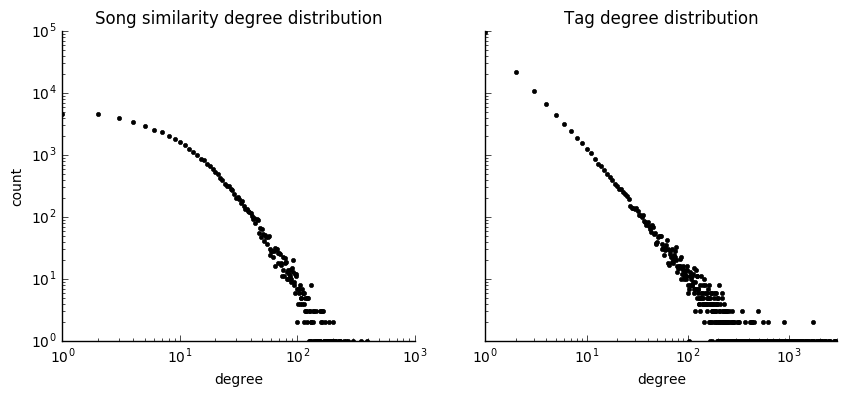

In [47]:
_,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
for i,degrees in enumerate([sim_degrees, tag_degrees]):
    edges = np.subtract(range(np.min(degrees),np.max(degrees) + 1),0.5)
    hist, _ = np.histogram(degrees,bins=edges)
    plotedges = np.add(edges[:-1],edges[1:])/2

    ax[i].loglog(plotedges,hist,".k")
    ax[i].set_xlabel("degree")
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].yaxis.set_ticks_position('left')

ax[0].set_ylabel("count")
ax[0].set_title("Song similarity degree distribution")
ax[1].set_title("Tag degree distribution")
ax[1].set_xlim(1,3000)
plt.savefig('tag_degree_distribution.png', bbox_inches='tight')
plt.show()

We notice that the amount of similar songs, that a song can have seems to have an upper bound. If we look at tags on the other hand, their degree seems to follow a clear power law. We can thus expect the maximum tag degree to grow unbounded as the network size increases. It is a scale-free network. The song similarity on the other hand will always be restricted to a small number of songs independent of the network size. 

The growth of the tag network could be modeled by a Barabási-Albert model [Barbarasi, 5.2]. The applied mechanism is called preferential attachment and causes that new nodes are more likely to connect to high degree nodes than to other nodes.

## Community detection

This section aims at finding groups of nodes in the graph that build communities. In order to do this, we will use the `louvain` module to obtain a good partition of the network. The `louvain` algorithm [Louvain] and other community detection algorithms aim at finding a partition of the network (i.e. grouping of nodes) that maximizes the sum of the modularity of the individual communities (as defined in [Barabasi, 9.4])

$$
M = \sum_c \frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2
$$
where:
* $L$: Total number of links
* $L_c$: Number of links in community $c$
* $k_c$: Total degree of all nodes within the community $c$

The result will be a partition where nodes are mostly connected to nodes within their own community and less to other communities. 

### Detecting tag communities

Now, we would like to find tags that are similar to each other by using the amount of songs they share as a similarity measure. Subsequently, we will run the `louvain` community detection algorithm on the obtained tag-similarity graph to find groups of tags that hopefully define a cluster of similar genres. As a preparation, we first get all the tagging relationships from the database and prepare a `Tag: [song_ids]` dictonary to store all songs, that are tagged by a specific tag.

In [48]:
query ="""
MATCH (s:Song)-[r:TAGGED]->(t:Tag)
RETURN s.id AS song, t.name as tag
"""
r = %cypher {query}
df = r.get_dataframe()

tags = {}
for row in df.iterrows():
    r = row[1]
    if r["tag"] not in tags:
        tags[r["tag"]] = {r["song"]}
    else:
        tags[r["tag"]].add(r["song"])

1063545 rows affected.


Now we define a similarity measure as the Jaccard similarity between two sets of songs

$$
J = \frac{\lvert S1 \bigcap S2\rvert}{\lvert S1 \bigcup S2\rvert}
$$

and use it to construct a graph with tags that are connected by a significant similarity (> 0.1 rather than 0, to decrease the number of edges). We then run the community detection algorithm on this graph for a selection of a few hundred high degree tags to find groups of tags that are forming communities. 

In [50]:
import json
from networkx.readwrite import json_graph
import community

def sim(s1,s2):
    isec = len(s1 & s2)
    return isec / float(len(s1) + len(s2) - isec)

select_tags = [t for t,s in tags.iteritems() if len(s) > 180 and not t.isdigit()]
N = len(select_tags)

print "%d tags selected" % N

simG = nx.Graph()
for i in range(N):
    for j in range(i,N):
        if sim(tags[select_tags[i]],tags[select_tags[j]]) > 0.1:
            simG.add_edge(select_tags[i],select_tags[j])
            
p = community.best_partition(max(nx.connected_component_subgraphs(simG), key=len))
nx.set_node_attributes(simG,"group",p)
# print all tags of one community
print [key for key,val in p.iteritems() if val == 12]

485 tags selected
[u'Smooth Jazz', u'jazz', u'swing', u'jazzy', u'jazz vocal', u'vocal jazz', u'vocal']


As we can see for this particular community (and for others, see webpage) we obtain groups of tags that refer to similar kinds of music. Although certain tags within a group definitely share songs with other genres, the high modularity within this group makes them end up in one community.

## Natural Language Processing

### Characteristic words for tags

In order to find out what words are characteristic for the lyrics of songs from certain tags we will use the TF-IDF score to rank words. While the TF (term frequency) is individual to each document, the IDF (inverse document frequency) is a global score for each unique word. While the TF score is simply the number of times a term occurs in a document, we can compute the IDF score by 
$$
IDF_i = log\left(\frac{N}{n_i}\right) 
$$
with 

* $N$: number of songs with lyrics
* $n_i$: number of songs that contain word $i$

The TF-IDF score defined by
$$
TFIDF = TF\cdot IDF
$$
now provides a balanced measure of how often a term occurs in a document and how unique the term is with respect to all documents.

We will let the database do the IDF calculation by

In [38]:
query = """
MATCH (s:Song)-[:CONTAINS]->(:Word)
WITH COUNT(DISTINCT s) as songCount
MATCH (w:Word)<-[:CONTAINS]-(s:Song)
RETURN DISTINCT coalesce(w.unstemmed, w.word) as word, log10(songCount/toFloat(COUNT(DISTINCT s))) as IDF
"""
r = %cypher {query}
idf_df = r.get_dataframe()
idf_df.set_index("word",inplace=True)

5000 rows affected.


In [39]:
print "Words with lowest IDF:"
print idf_df.sort_values("IDF",ascending = True).head(5)

Words with lowest IDF:
           IDF
word          
the   0.093217
a     0.107775
to    0.115308
and   0.122377
i     0.128843


Here we can see, very common words get a low IDF score, which says they carry little information if we observe them. Indeed, these words tell us nothing about the particular topic of a text. 

We will now compute the TF-IDF scores for the 100 most frequent tags using results from all songs tagged by a one of those tags.

In [40]:
%%capture
from nltk.corpus import stopwords
query = """
MATCH (t:Tag)<-[r:TAGGED]-()
RETURN distinct t.name as tag,COUNT(r) as c
ORDER BY c DESC
LIMIT 100
"""
r = %cypher {query}
df = r.get_dataframe()
tags = df["tag"].values.tolist()

tags.append("Gangsta Rap")
tags.append("death metal")
tags.append("political")
tags.append("country")
tags = list(set(tags))

exclude = set(stopwords.words('english'))
tf_idf = {}
tf = {}
for current_tag in tags:
    query = """
        MATCH (t:Tag {name:{current_tag}})<-[:TAGGED]-(:Song)-[r:CONTAINS]->(w:Word)
        RETURN DISTINCT coalesce(w.unstemmed, w.word) as word, COUNT(r) as count
        ORDER BY count DESC
    """
    r = %cypher {query}
    df = r.get_dataframe()
    tf[current_tag] = {word[0] : word[1] for word in df.values if word[0] not in exclude}
    tf_idf[current_tag] = {word[0] : idf_df.get_value(word[0],"IDF")*word[1] for word in df.values if word[0] not in exclude}

In [41]:
import string
select_tags = ["Gangsta Rap","spanish","black metal","rock n roll","romantic","Dreamy","christian"]
for tag in select_tags:
    keywords = [v[0] for v in sorted(tf_idf[tag].items(),key=lambda v: -v[1])[:10]]
    print "%-20s : %s" % (tag, string.join(keywords,sep=", "))

Gangsta Rap          : nigga, shit, bitch, ass, fuck, ai, niggaz, yo, 'em, fuckin'
spanish              : el, que, de, en, la, mi, por, lo, es, te
black metal          : death, blood, dark, soul, black, die, god, dead, eternal, fire
rock n roll          : got, baby, yeah, night, oh, love, gonna, well, get, come
romantic             : love, heart, feel, say, know, would, oh, never, baby, want
Dreamy               : love, feel, go, dream, know, like, eyes, come, could, time
christian            : lord, life, god, heart, jesus, live, see, fall, love, take


Here we see the top 10 words by TF-IDF score for some selected tags. It is obvious that the used words hint at possible tags. This could be used to find the most probable tags given the lyrics of a song. Naturally, it was a lot less clear for popular tags like "rock" or "pop" which did not show any significant keywords. 

Finally, we can arrange the tags in WordClouds to get a nice visualization of certain tags, where the result was very expressive. We use the tags "death metal", "Gangsta Rap", "political", and "country"

In [42]:
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def draw_wordcloud(tag, mask, ax):
    img_mask = misc.imread(mask,mode="RGB")
    keywords = " ".join([ word for k,v in tf_idf[tag].iteritems() for word in ["%s " % k] * int(10*v) if v > 0.5])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='rgb(255,255,255)', random_state=42,
                          mask=img_mask).generate(keywords).recolor(color_func=ImageColorGenerator(img_mask))
    ax.imshow(wordcloud)
    ax.axis("off")

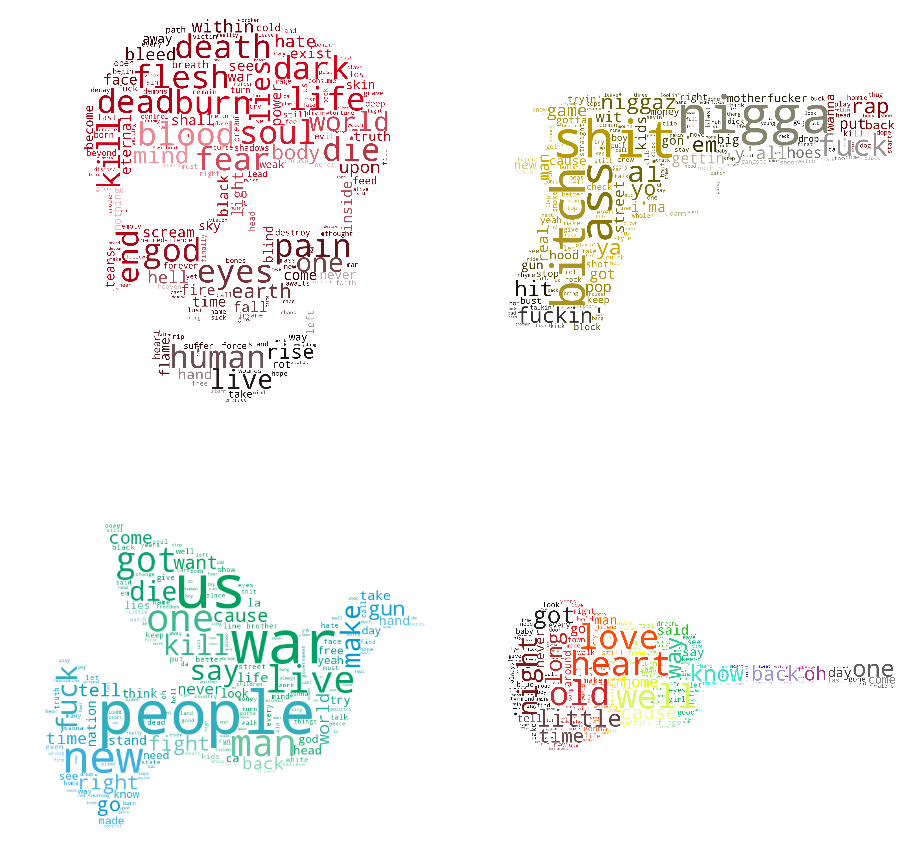

In [43]:
_,ax = plt.subplots(2,2,figsize=(11,11))
draw_wordcloud("death metal","./masks/death_colored.png",ax[0,0])
draw_wordcloud("Gangsta Rap","./masks/gangsta_colored.png",ax[0,1])
draw_wordcloud("political","./masks/political_colored.png",ax[1,0])
draw_wordcloud("country","./masks/rock_colored.png",ax[1,1])

## Sentiment analysis

Sentiment analysis is another approach of characterizing the data. During the research of [Dodds], the team obtained a set of 10222 (labMT 1.0) word and happiness score pairs indicating how much happiness the individual word conveys. We will use this list to define an average sentiment score for a set of words as 

$$
S = \frac{1}{N} \sum_{i=1}^N S_i
$$
where:
* $N$: the number of words for which sentiment data was available
* $S_i$: the sentiment value for word i

Having obtained the word counts for the top 100 tags we can use these to calculate an average sentiment score for each tag. What we yield is a ranking of how happy certain tags are on average.

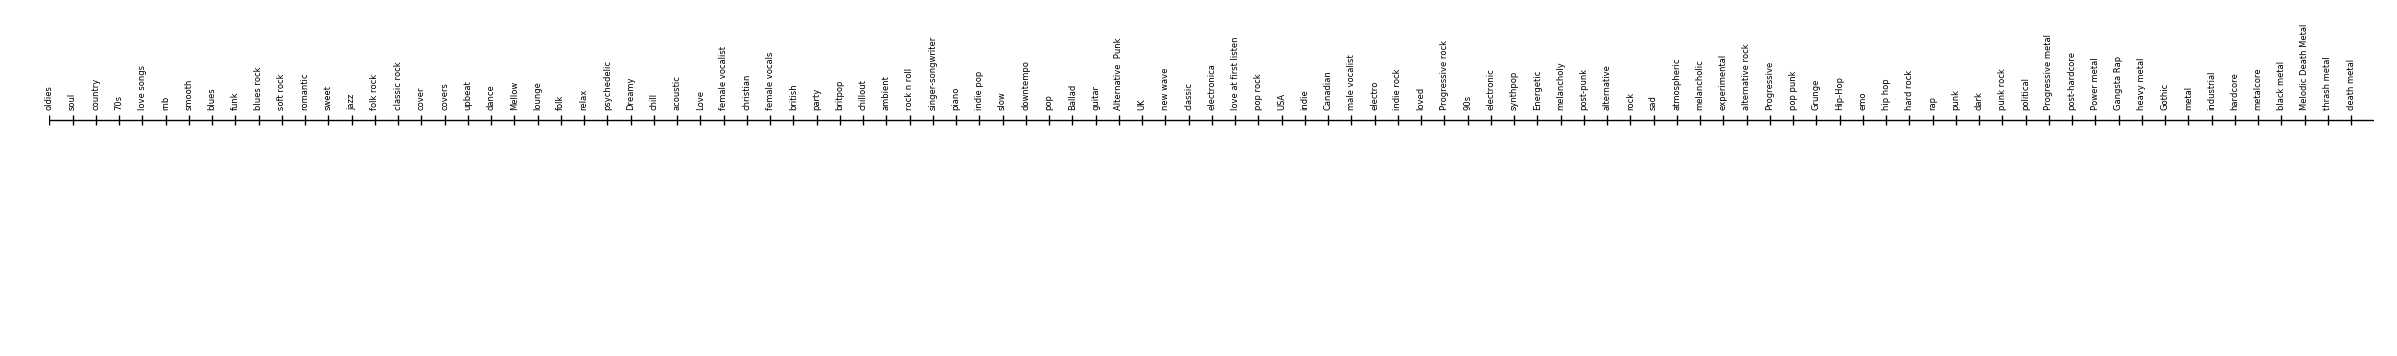

In [52]:
import io
import json
labmt_df = pd.read_csv("./songdata/labmt.txt",sep="\t", usecols=[0,2])
sentiment_map = {v[0]:v[1] for v in labmt_df.values}

def calculate_sentiment(wordcounts):
    count = 0
    sentiment = 0
    for k,v in wordcounts.iteritems():
        if k in sentiment_map:
            sentiment += v*sentiment_map[k]
            count += v
    return sentiment/count

sentiments = {}
for tag in tags:
    sentiments[tag] = calculate_sentiment(tf[tag])

with io.open("tag_sentiment.txt","w",encoding="UTF-8") as sentiment_file:
    sentiment_file.write(unicode(json.dumps(sentiments,ensure_ascii=False)))
    
exclude = {"spanish", "german", "latin"} # exclude foreign language tags
    
tags_ordered = [t[0] for t in sorted(sentiments.items(),key=lambda v: -v[1]) if t[0] not in exclude]

plt.rcParams["figure.figsize"] = (30,4)
plt.hlines(1,0,len(tags_ordered))  # Draw a horizontal line
plt.eventplot(range(len(tags_ordered)), orientation='horizontal', colors='k',linelengths=0.1)
plt.ylim(-1,2)
plt.axis("off")
ax = plt.gca()

for i,tag in enumerate(tags_ordered):
    ax.text(i,1.1,tag,ha='center',va='bottom',rotation=90,fontsize=6)

plt.savefig("sentiment_ordered.png",transparent=True,dpi=300,bbox_inches='tight')
plt.show()

In [53]:
print "%-20s\t%s" % ("TOP 5","BOTTOM 5")
for i in range(5):
    print "%-20s\t%s" % (tags_ordered[i],tags_ordered[-i-1])

TOP 5               	BOTTOM 5
oldies              	death metal
soul                	thrash metal
country             	Melodic Death Metal
70s                 	black metal
love songs          	metalcore


Oldies apparently have the happiest lyrics, while metal in general seems to be a very unhappy genre. This is probably because it reflects a lot about dark topics like death which have a very low happyness score. The entire scale gives an insight into how positive the lyrics of certain genre are in comparison to other genres.

### Average sentiment over the years

Another aspect we are interested in is if there is a change in the average sentiment of song lyrics over the years. For that purpose we let the database aggregate all word counts for songs of the particular years and from that determine the average sentiment of each year.

In [4]:
from IPython.display import clear_output
#getting list of years
dbQueryGetY = """
MATCH (s:Song)
WHERE s.year IS NOT NULL
RETURN distinct s.year as year
ORDER BY year ASC
"""
#creating list of years
r = %cypher {dbQueryGetY}
dataFrame = r.get_dataframe()
years = dataFrame["year"].values.tolist()

#reading average happiness values from the LabMT wordlist
data= pd.read_csv("songdata/labmt.txt",sep="\t", usecols=[0,2])
happinessMap = {v[0]:v[1] for v in data.values}
print "System: Happines list loaded"

yearDataFrame = {}
#looping through the years to get word list and count
for currYear in years:
    clear_output()
    print "Processing year %d" % currYear
    dbQueryGetWPY = """
    MATCH (s:Song {year: {currYear}})-[r:CONTAINS]->(w:Word)
    RETURN distinct w.unstemmed as wUns, sum(r.count) as wCount
    """
    r = %cypher {dbQueryGetWPY}
    
    dataFrame = r.get_dataframe()
    yearDataFrame[currYear] = dataFrame.values.tolist()   
print "System: Data per year loaded"

Processing year 2010
3433 rows affected.
System: Data per year loaded


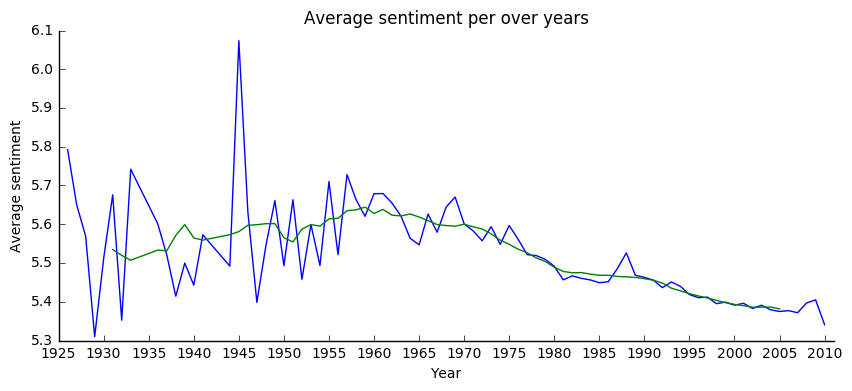

In [7]:
from nltk.corpus import stopwords
from scipy.signal import convolve
#setting stopwords to filter
stopwords = set(stopwords.words('english'))

#defining an average sentiment calculation method
def calcSent(array):
    count = 0
    sent = 0
    for k,v in array:
        if k in happinessMap:
            if k not in stopwords: #exclude stopwords
                sent += v*happinessMap[k]
                count += v
    return sent/count
sentiments={}
sv={}
#calcualating average sentiment per year
for year in years:
    sentiments[year] = calcSent(yearDataFrame[year])

#plot the graph
lists = sorted(sentiments.items())
x,y = zip(*lists)
fig = plt.figure(figsize=(10,4))
axes = fig.add_subplot(111)
axes.plot(x,y)

mov_y = convolve(y,[0.1]*10)[10:-9]
mov_x = x[5:-5]
axes.plot(mov_x,mov_y)

axes.set_title("Average sentiment per over years")
axes.set_xticks(np.arange(1925,2015,5))
axes.set_xlim(1925,2011)
axes.set_xlabel("Year")
axes.set_ylabel("Average sentiment")
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.xaxis.set_ticks_position('bottom')
axes.yaxis.set_ticks_position('left')
plt.show()

Here we can see the calculated average sentiment values over the years included in our dataset. As we have previously seen, the dataset contains only few very old songs and more and more songs in the recent years. This is why the graph fluctuates a lot in the early years, as we have a high degree of uncertainty. The more songs are available per year, the more stable the curve gets which also indicates the significance of the observed decline in those years. 

The green line shows a 10 year moving average which gives us a good indication of how sentiment developed over the years. There certainly have been happier times than these days. In the more recent half of the graph, we can see two local peaks, one around the year of 1968 (possibly because of the hippie movement) and one in the late eighties. 

The overall happiest times seem to have been during the late fifties and sixties. It may be a coincidence due to the mentioned uncertainty, but the by far largest value is found around the time when the second world war ended.

## Conclusion

So far, we managed to get interesting overview of the data that was provided in the dataset and we are satisfied with the result we got. We were able to capture ideas about the data from different sides and got a better look on how interesting music metadata can be.

### Difficulties
Of course, there were some drawbacks. Data acquisition was a bit problematic since it was taking a lot of time to populate the database. As a result, we were forced to limit amount of data we were working with, meaning that the end results may be a bit skewed compared to what we could get if we would be able to process the entire dataset. But even then, we will never be able to capture all music of all time, so it is questionable if that is even desirable. Already at the size of the working database right now, it was time consuming to perform certain operations and this would only increase with a higher amount of data.

Finally, as always with real data, there is noise, outliers and missing values. In our case, we had to cope with incomplete information. As the data came from different sources (meta data, release year, lyrics), some songs are missing a release year, don't have any similar songs, or don't have tags. 

### Summary
During this project we learned that songs can be seen as a dense network. Through similarity relationships, basically all songs are connected even across genres. We learned that the vocabulary of a song can point us into the direction of the right genre. Concerning the sentiment analysis, of course songs from different genres vary in the average sentiment. But it is interesting to be able to map popular tags on a scale from positive to negative sentiment. Over the years, there were actually certain historic trends which are reflected in the lyrics of those years' music.
Finally, utilizing both similarity data and tags to find tag communities showed that songs build genre clusters that characterize a general area of music. 
 


## Appendix: Data preparation

The previous analysis assumes that the data is available in the database. This appendix describes how the database was populated from the original raw dataset and provides the implementation for doing so.

The data from different files was merged song-wise and inserted into a Neo4j graph database. It is queried by the query language Cypher for which the [`ipython-cypher`](https://github.com/versae/ipython-cypher) module provides a convenient api. 


The lyrics file includes one line at the beginning introducing the 5000 words in the vocabulary

`%i,the,you,to,and,a,me,it,not,in,my,is,of,your,that,do,on,are,we,am,will,all,for,no,be,have,love,so,know,[...]`

after this, the words are referenced by the individual entries through their index in this list. That is, after this line there is one entry per line like 

`TRAAAAV128F421A322,4623710,1:6,2:4,3:2,4:2,5:5,6:3,7:1,8:1,11:1,12:2,13:3,[...]`

including the LastFM track ID (the one we will use), the musiXmatch ID, and then a list of `word index : count` pairs to construct the bag of words. 

After having setting up a database with the appropriate indices and constraints, we first create the vocabulary of the bag of words lyrics including the `reverse_stemming.txt` list, which contains the most probable unstemmed version of a stemmed word. This will be essential for the sentiment analysis where unstemmed words are used. 

In [9]:
%reload_ext cypher
import io
import json
import numpy as np
import pandas as pd

In [10]:
with io.open("./songdata/lyrics.txt","r",encoding="UTF-8") as lyrics_file:
    # create words
    for line in lyrics_file:
        if line.startswith("%"):
            stemming_df = pd.read_csv("./songdata/reverse_stemming.txt",sep="<SEP>",engine="python")
            stemming_map = {v[0].decode("UTF-8"):v[1].decode("UTF-8") for v in stemming_df.values}
            props = [ {"word": word,
                       "index": i+1, 
                       "unstemmed": stemming_map.get(word,"") } 
                       for i,word in enumerate(line[1:].split(","))]
            # Execute query adding all words to the database
            %cypher UNWIND {props} AS props MERGE (w:Word {index:props.index}) ON CREATE SET w=props
            break
    lyrics_file.seek(0)
    print "Created Vocabulary"

0 rows affected.
Created Vocabulary


Now we iterate through the lyrics file and for each song obtain meta data from the LastFM data and add the song to the database including its similar songs (i.e. they are created as "empty" nodes if they don't exist yet). This process can be stopped and run again to pupulate the database in several runs (it takes a long time). As the database queries are the main bottleneck, we obtain all track_ids of songs that already have full data from the database first and only run queries for new songs.

In [11]:
# find all songs in the database that have lyric information
from IPython.display import clear_output
print "Getting database songs..."
limit = 10000
skip = 0
added = 0
all_saved_ids = set()
while True:
    query = """
        MATCH (s:Song)
        WHERE EXISTS((s)-[:CONTAINS]->(:Word))
        RETURN s.id AS track_id
        SKIP {skip}
        LIMIT {limit}
    """
    result = %cypher {query}
    saved_ids = {row.track_id for row in result.get_dataframe().itertuples()}
    skip += len(saved_ids)
    if len(saved_ids) == 0:
        break
    all_saved_ids.update(saved_ids)

try:
    # iterate through songs and insert new ones
    with io.open("./songdata/lyrics.txt","r",encoding="UTF-8") as lyrics_file:
        for line in lyrics_file:
            # jump over comments
            if line.startswith("#") or line.startswith("%"):
                continue

            # jump over empty lines
            parts = line.strip().split(",")
            if len(parts) == 1:
                continue

            # get id and word counts
            track_id = parts[0]
            if track_id in all_saved_ids:
                continue
                
            wordcounts = []
            for part in parts[2:]:
                entry = part.split(":")
                wordcounts.append({"index":int(entry[0]),"count":int(entry[1])})

            # load song metadata
            path = "%s/%s/%s/%s.json" % (track_id[2],track_id[3],track_id[4],track_id)
            try:
                with io.open("./songdata/meta/" + path,"r") as meta_file:
                    data = json.loads(meta_file.read())
            except:
                continue

            # prepare properties
            title = data["title"]
            artist = data["artist"]
            tags = [ {"name":tag[0],"score":tag[1]} for tag in data["tags"] if int(tag[1]) > 0 ]
            similars = [ {"id":similar[0],"score":similar[1]} 
                        for similar in data["similars"]
                        if similar[1] > 0.05 ]
            print "Adding track %s with %d similars, %d tags, %d words" % (track_id,len(similars),len(tags),len(wordcounts))
            # run query
            query = """
                    MERGE (s:Song {id:{track_id}})
                    ON CREATE SET
                        s.id = {track_id}, 
                        s.title = {title}, 
                        s.artist = {artist}
                    ON MATCH SET 
                        s.title = {title}, 
                        s.artist = {artist}
                    WITH s
                    UNWIND {similars} as similars
                    MATCH (sim:Song {id:similars.id})
                    MERGE (s)-[:SIMILAR {score: similars.score}]->(sim)
                    WITH s
                    UNWIND {wordcounts} as wordIDs
                    MATCH (s),(w:Word {index:wordIDs.index})
                    MERGE (s)-[:CONTAINS {count:wordIDs.count}]->(w)
                    WITH s
                    UNWIND {tags} as tag
                    MERGE (t:Tag {name:tag.name})
                    WITH t,tag,s
                    MERGE (s)-[:TAGGED {score: tag.score}]->(t)
            """
            %cypher {query}
            clear_output()
            added += 1
            print "Filling database... (%d added)" % added
except KeyboardInterrupt:
    pass

Filling database... (5 added)
Adding track TRAABJV128F1460C49 with 3 similars, 2 tags, 86 words


Finally we add year information for all songs where it is available

In [ ]:
with io.open("./songdata/tracks_per_year.txt","r",encoding="UTF-8") as year_file:
    year_data = {}
    for line in year_file:
        parts = line.split("<SEP>")
        year_data[parts[1]] = int(parts[0])
        
limit = 1000
skip = 0
while True:
    # get a batch of nodes that have no year
    query = """
        MATCH (s:Song)
        WHERE (s)-[:CONTAINS]->()
        AND s.year IS NULL
        RETURN s.id AS track_id
        SKIP {skip}
        LIMIT {limit}
    """
    result = %cypher {query}
    ids = [rec.track_id for rec in result.get_dataframe().itertuples()]
    
    if not ids: 
        break
    else:
        years = [{"id" : track, "year": year_data[track]} for track in ids if track in year_data]
        skip += limit-len(years) 
        query = """
            UNWIND {years} as year
            MATCH (s:Song {id:year.id})
            SET s.year = year.year
        """
        %cypher {query}

## References

__[Dodds]__ Dodds PS, Harris KD, Kloumann IM, Bliss CA, Danforth CM (2011) Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter. PLoS ONE 6(12): e26752. (http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752)

__[Barabasi]__ Albert-Lázló Barabási, Network Science, (http://barabasi.com/networksciencebook/)

__[Louvain]__ Vincent D. Blondel, Jean-Loup Guillaume, Renaud Lambiotte, Etienne Lefebvre (2008) Fast unfolding of communities in large networks, (https://arxiv.org/abs/0803.0476v2)